In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import rotate
import Utils
from Utils import Constants
import cv2
from facenet_pytorch import InceptionResnetV1
from Models import *
from DataLoaders import *
import copy

In [5]:
# train_labels = pd.read_csv('train_data_clean.csv')
# test_labels = pd.read_csv('test_data_clean.csv')
# validation_labels = pd.read_csv('validation_data_clean.csv')
# train_labels

In [8]:
loader = TripletFaceGenerator(pd.read_csv('train_data_augmented_balanceddual.csv'),Constants.data_root,skintone_patch_anchor_prob=0,validation=False,smote_prob=.5)
[x,y] = next(iter(loader))
x[0]

(4869, 167)


tensor([[[[0.3289, 0.3306, 0.3342,  ..., 0.5000, 0.4417, 0.4948],
          [0.3314, 0.3346, 0.3351,  ..., 0.4817, 0.4601, 0.4430],
          [0.3299, 0.3360, 0.3431,  ..., 0.5030, 0.5116, 0.4616],
          ...,
          [0.0216, 0.0146, 0.0130,  ..., 0.0130, 0.0091, 0.0061],
          [0.0249, 0.0159, 0.0117,  ..., 0.0118, 0.0089, 0.0048],
          [0.0290, 0.0180, 0.0117,  ..., 0.0136, 0.0107, 0.0066]],

         [[0.3826, 0.3831, 0.3857,  ..., 0.3584, 0.2937, 0.3442],
          [0.3905, 0.3875, 0.3875,  ..., 0.3459, 0.3147, 0.2993],
          [0.3845, 0.3886, 0.3956,  ..., 0.3805, 0.3664, 0.3142],
          ...,
          [0.0911, 0.0829, 0.0850,  ..., 0.0849, 0.0808, 0.0776],
          [0.0943, 0.0854, 0.0835,  ..., 0.0836, 0.0808, 0.0767],
          [0.0947, 0.0838, 0.0812,  ..., 0.0854, 0.0826, 0.0785]],

         [[0.3841, 0.3853, 0.3889,  ..., 0.2742, 0.2167, 0.2722],
          [0.3885, 0.3895, 0.3898,  ..., 0.2643, 0.2403, 0.2273],
          [0.3858, 0.3908, 0.3972,  ..., 0

In [ ]:
images = [imgs_to_np(xx) for xx in x]
Utils.plot_selection([images[0][0],images[1][0],images[2][0],images[0][2],images[1][2],images[2][2],images[0][3],images[1][3],images[2][3]])

In [12]:
train_labels = pd.read_csv('train_data_augmented_balanceddual.csv')
validation_labels = pd.read_csv('validation_data_augmented_balanceddual.csv')
labels = pd.concat([train_labels,validation_labels]).drop('Unnamed: 0',axis=1)
labels['subgroup'] = labels.apply(lambda row: '-'.join([str(row[s]) for s in Constants.labels]),axis=1)
labels.subgroup

0       0-1-0
1       5-0-1
2       1-0-1
3       1-1-0
4       7-1-0
        ...  
1706    3-1-0
1707    2-2-0
1708    1-0-1
1709    4-1-1
1710    0-1-0
Name: subgroup, Length: 8553, dtype: object

Text(0.5, 1.0, 'Distribution of skin tone by age and gender')

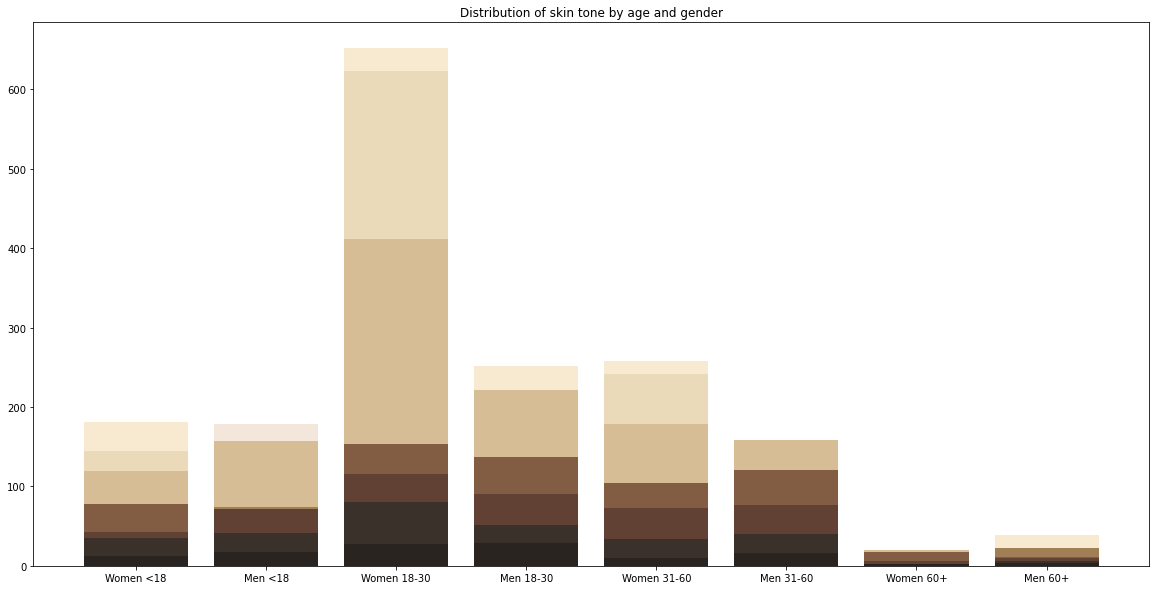

In [25]:
def skintone(level):
    rgb = (0,0,0)
    if level == 0:
        rgb = (246, 237, 228)
    elif level == 1:
        rgb = (243, 231, 219)
    elif level == 2:
        rgb = (247, 234, 208)
    elif level == 3:
        rgb = (234, 218, 186)
    elif level == 4:
        rgb = (215, 189, 150)
    elif level == 5:
        rgb = (160, 126, 86)
    elif level == 6:
        rgb = (130, 92,67)
    elif level == 7:
        rgb = (96, 65, 52)
    elif level == 8:
        rgb = (58,49,42)
    else:
        rgb = (41,36,32)
    return (rgb[0]/255, rgb[1]/255, rgb[2]/255)

xtemp = []
ytemp = []
colors = []
ages = {
    '0': '<18',
    '1': '18-30',
    '2': '31-60',
    '3': '60+',
}
genders = {
    '0': 'Women',
    '1': 'Men',
}
for subgroup,subdf in labels.groupby('subgroup'):
    xtemp.append(subdf.shape[0])
    name = genders.get(subgroup[-1],'') + ' ' + ages.get(subgroup[2],'')
    ytemp.append(name)
    colors.append(skintone( int(subgroup[0]) ))
fig, ax = plt.subplots(1,1,figsize=(20,10))
ax.bar(ytemp,xtemp,color=colors)
ax.set_title('Distribution of skin tone by age and gender')

In [ ]:
def save_train_history(model,history,root=''):
    model_name = model.get_identifier()
    
    df = pd.DataFrame(history)
    df['model'] = model_name
    string = root + 'results/history_' + model_name + '.csv'
    df.to_csv(string,index=False)
    print('saved history to',string)
    return df, string

def train_model(model,
                train_df,
                validation_df,
                root,
                epochs=300,
                lr=.0001,
                batch_size=200,
                patience = 20,
                loss_weights = [5,2,1],
                save_path=None,
                histogram =False,
                upsample=False,
                random_upsample=True,
                softmax_upsample_weights=False,
                upsample_validation=False,
                random_upsample_validation=False,
                **kwargs,
               ):
    if save_path is None:
        save_path = root + 'models/'+ model.get_identifier()
        if random_upsample:
            
            save_path += '_rbalanced'
            if softmax_upsample_weights:
                save_path += 'soft'
        elif upsample:
            save_path += '_balanced'
    if upsample:
        patience = int(patience/5) + 1
    train_loader = FaceGenerator(train_df,Constants.data_root,
                                 batch_size=batch_size,
                                 upsample=upsample,
                                 random_upsample=random_upsample,
                                 softmax=softmax_upsample_weights,
                                 **kwargs)
    validation_loader = FaceGenerator(validation_df,Constants.data_root,
                                      validation=True,
                                      batch_size=batch_size,
                                      upsample=upsample_validation,
                                     random_upsample=random_upsample_validation,
                                     softmax=softmax_upsample_weights,
                                      **kwargs)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.train()
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    format_y = lambda y: y.long().to(device)
    
    def get_loss(m,xin,ytrue):
        outputs = m(xin)
        losses = [loss_fn(ypred.float(),format_y(y)) for y,ypred in zip(ytrue,outputs)]
        l1 = torch.mul(loss_weights[0],losses[0])
        l2 =  torch.mul(loss_weights[1],losses[1])
        l3 =  torch.mul(loss_weights[2],losses[2])
        total_losses = l1 + l2 + l3
        return outputs,total_losses

    
    def train_epoch():
        running_loss = 0
        running_accuracy = [0,0,0]
        curr_loss = 0
        count = 0
        for i, [x_batch, y_batch] in enumerate(train_loader):
            optimizer.zero_grad()
            if histogram:
                xh = torch_color_histogram(torch.clone(x_batch))
                xh = xh.to(device)
                xxb = x_batch.to(device)
                xh.requires_grad_(True)
                xxb.requires_grad_(True)
                xb = [xxb,xh]
            else:
                xb = x_batch.to(device)
                xb.requires_grad_(True)
            outputs,total_losses = get_loss(model, xb,y_batch)
            total_losses.backward()
            optimizer.step()
            running_loss += total_losses.item()
            print('curr loss',total_losses.item(), 'step',i,' | ',end='\r')
            count += 1
            with torch.no_grad():
                for i,(y,ypred) in enumerate(zip(y_batch,outputs)):
                    accuracy = Utils.categorical_accuracy(ypred.float(),format_y(y))
                    running_accuracy[i] += accuracy.item()
        return running_loss/count, [a/count for a in running_accuracy]
    
    def val_epoch():
        running_loss = 0
        running_accuracy = [0,0,0]
        running_f1 = [0,0,0]
        count = 0
        for i, [x_batch, y_batch] in enumerate(validation_loader):
            if histogram:
                xb = add_batch_histogram(x_batch,device=device,grad=False)
            else:
                xb = x_batch.to(device)
            outputs = model(xb)
            outputs,total_losses = get_loss(model,xb,y_batch)
            running_loss += total_losses.item()
            count += 1
            for i,(y,ypred) in enumerate(zip(y_batch, outputs)):
                accuracy = Utils.categorical_accuracy(ypred.float(),format_y(y))
                f1, precision, recall = Utils.macro_f1(torch.argmax(ypred.float(),axis=1),format_y(y))
                running_f1[i] += f1.item()
                running_accuracy[i] += accuracy.item()
        return running_loss/count, [a/count for a in running_accuracy], [f/count for f in running_f1]
    
    
    best_val_loss = 100000
    steps_since_improvement = 0
    hist = []
    best_weights = model.state_dict()
    print('model being saved to',save_path)
    for epoch in range(epochs):
        print('epoch',epoch)
        model.train(True)
        avg_loss, avg_acc = train_epoch()
        print('train loss', avg_loss, 'train accuracy', avg_acc)
        model.eval()
        val_loss, val_acc, val_f1 = val_epoch()
        print('val loss', val_loss, 'val accuracy', val_acc, 'val f1',val_f1)
#         torch.save(model.state_dict(), save_path + '_epoch' + str(epoch))
        if best_val_loss > val_loss:
            best_weights = copy.deepcopy(model.state_dict())
            best_val_loss = val_loss
            steps_since_improvement = 0
            if epoch > 1:
                torch.save(model,save_path)
                torch.save(model.state_dict(),save_path+'_states')
        else:
            steps_since_improvement += 1
        
        hist_entry = {
            'epoch': epoch,
            'train_loss': avg_loss,
            'train_acc':avg_acc,
            'val_loss':val_loss,
            'val_acc': val_acc,
            'lr': lr,
            'loss_weights': '_'.join([str(l) for l in loss_weights])
        }
        hist.append(hist_entry)
        save_train_history(model,hist,root=root)
        if steps_since_improvement > patience:
            break
    return model,hist,best_val_loss


# models= [
#     TripletModel(encoder=TripletFacenetEncoder(base_model=ResNet18(),base_name='resnetbase',embedding_dropout=.1)),
#     TripletModel(encoder=TripletFacenetEncoder(base_model=ResNet18(),base_name='resnetbase',embedding_dropout=.5)),
#     TripletModel(encoder=TripletFacenetEncoder(base_model=DenseNet(),base_name='densenetbase',embedding_dropout=.5)),
#     TripletModel(encoder=TripletFacenetEncoder(base_model=MobileNet(),base_name='mobilenetbase',embedding_dropout=.5)),
#     TripletModel(encoder=TripletFacenetEncoder(base_name='facenetbase',embedding_dropout=.5)),
# ]

def get_model(file,model=None):
    if model is None:
        model = torch.load(Constants.model_folder + file).to(torch.device('cpu'))
    model.load_state_dict(torch.load(Constants.model_folder + file + '_states'))
    model.eval()
    return model
pretrain_files = [
    'dualencoder_resnetbase_h400_ed3triplet_decoder__st600_a400_g400_std2_ad2_gd2_rbalanced_pretrain',
    'dualencoder_resnetbase_h400_ed5triplet_decoder__st600_a400_g400_std2_ad2_gd2_rbalanced_pretrain',
    'dualencoder_densenetbase_h400_ed5triplet_decoder__st600_a400_g400_std2_ad2_gd2_rbalanced_pretrain',
    'dualencoder_mobilenetbase_h400_ed5triplet_decoder__st600_a400_g400_std2_ad2_gd2_rbalanced_pretrain',
    'dualencoder_dualfacenet_h400_ed5triplet_decoder__st600_a400_g400_std2_ad2_gd2_rbalanced_pretrain',
    'dualencoder_resent_flat_h400_ed5triplet_decoder__st600_a400_g400_std2_ad2_gd2_rbalanced_pretrain',
    'dualencoder_resnet_flatbias_h400_ed5triplet_decoder__st600_a400_g400_std2_ad2_gd2_pretrain'
]
models = [get_model(file) for file in pretrain_files]

res = []
for model in models:
    batch_size=50
    if 'densenet' in model.get_identifier():
        batch_size=5
    m,h,v = train_model(
        model,
        train_labels,
        validation_labels,
        Constants.data_root,
        batch_size=batch_size,
        lr=.0001,
    )
    entry = (m.get_identifier(),v)
    print('________________________________')
    print(entry)
    print('_______________________________')
    res.append(entry)
res

In [ ]:
umodels= [
    TripletModel(encoder=TripletFacenetEncoder(base_model=ResNet18(),base_name='resnetuntrained',embedding_dropout=.1)),
    TripletModel(encoder=TripletFacenetEncoder(base_model=ResNet18(),base_name='resnetuntrained',embedding_dropout=.5)),
    TripletModel(encoder=TripletFacenetEncoder(base_model=ResNet18(),base_name='resnetuntrained',embedding_dropout=.7)),
    TripletModel(encoder=TripletFacenetEncoder(base_model=MobileNet(),base_name='mobilenetuntrained',embedding_dropout=.5)),
    TripletModel(encoder=TripletFacenetEncoder(base_name='facenetuntrained',embedding_dropout=.5)),
]

for model in umodels:
    batch_size=50
    m,h,v = train_model(
        model,
        train_labels,
        validation_labels,
        Constants.data_root,
        batch_size=batch_size,
        lr=.0001,
    )
    entry = (m.get_identifier(),v)
    print('________________________________')
    print(entry)
    print('_______________________________')
    res.append(entry)
res

In [ ]:
import torchvision